<a href="https://colab.research.google.com/github/ELSOUDY2030/Semantic-Segmentation/blob/main/Semantic%20Segmentation%20for%20Self-Driving%20Cars(colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import glob as gb
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import tensorflow.keras.layers as tfl
from imgaug.augmentables.segmaps import SegmentationMapsOnImage


In [ ]:
!pip install kaggle

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d mateuszbuda/lgg-mri-segmentation

 99% 710M/714M [00:06<00:00, 128MB/s]
100% 714M/714M [00:06<00:00, 119MB/s]


In [ ]:
!unzip lgg-mri-segmentation.zip

Streaming output truncated to the last 5000 lines.
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7294_19890104/TCGA_DU_7294_19890104_9_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_1.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_10_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_11_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_12_mask.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_19910324/TCGA_DU_7298_19910324_13.tif  
  inflating: lgg-mri-segmentation/kaggle_3m/TCGA_DU_7298_1

In [ ]:
classes = ['dataB', 'dataD', 'dataA', 'dataC', 'dataE']

In [ ]:
img_path =   [f"{os.path.join('/content/', i, i, 'CameraRGB')}/{x}" for i in classes for x in os.listdir(os.path.join('/content/', i, i, 'CameraRGB')) if not x.startswith('.')]
masks_path = [f"{os.path.join('/content/', i, i, 'CameraSeg')}/{x}" for i in classes for x in os.listdir(os.path.join('/content/', i, i, 'CameraSeg')) if not x.startswith('.')]

<ipython-input-8-dbf4c92e1973>:6: DeprecationWarning: This function is deprecated. Please call randint(0, 5000 + 1) instead
  for i,x in enumerate(np.random.random_integers(0,5000,nub)):


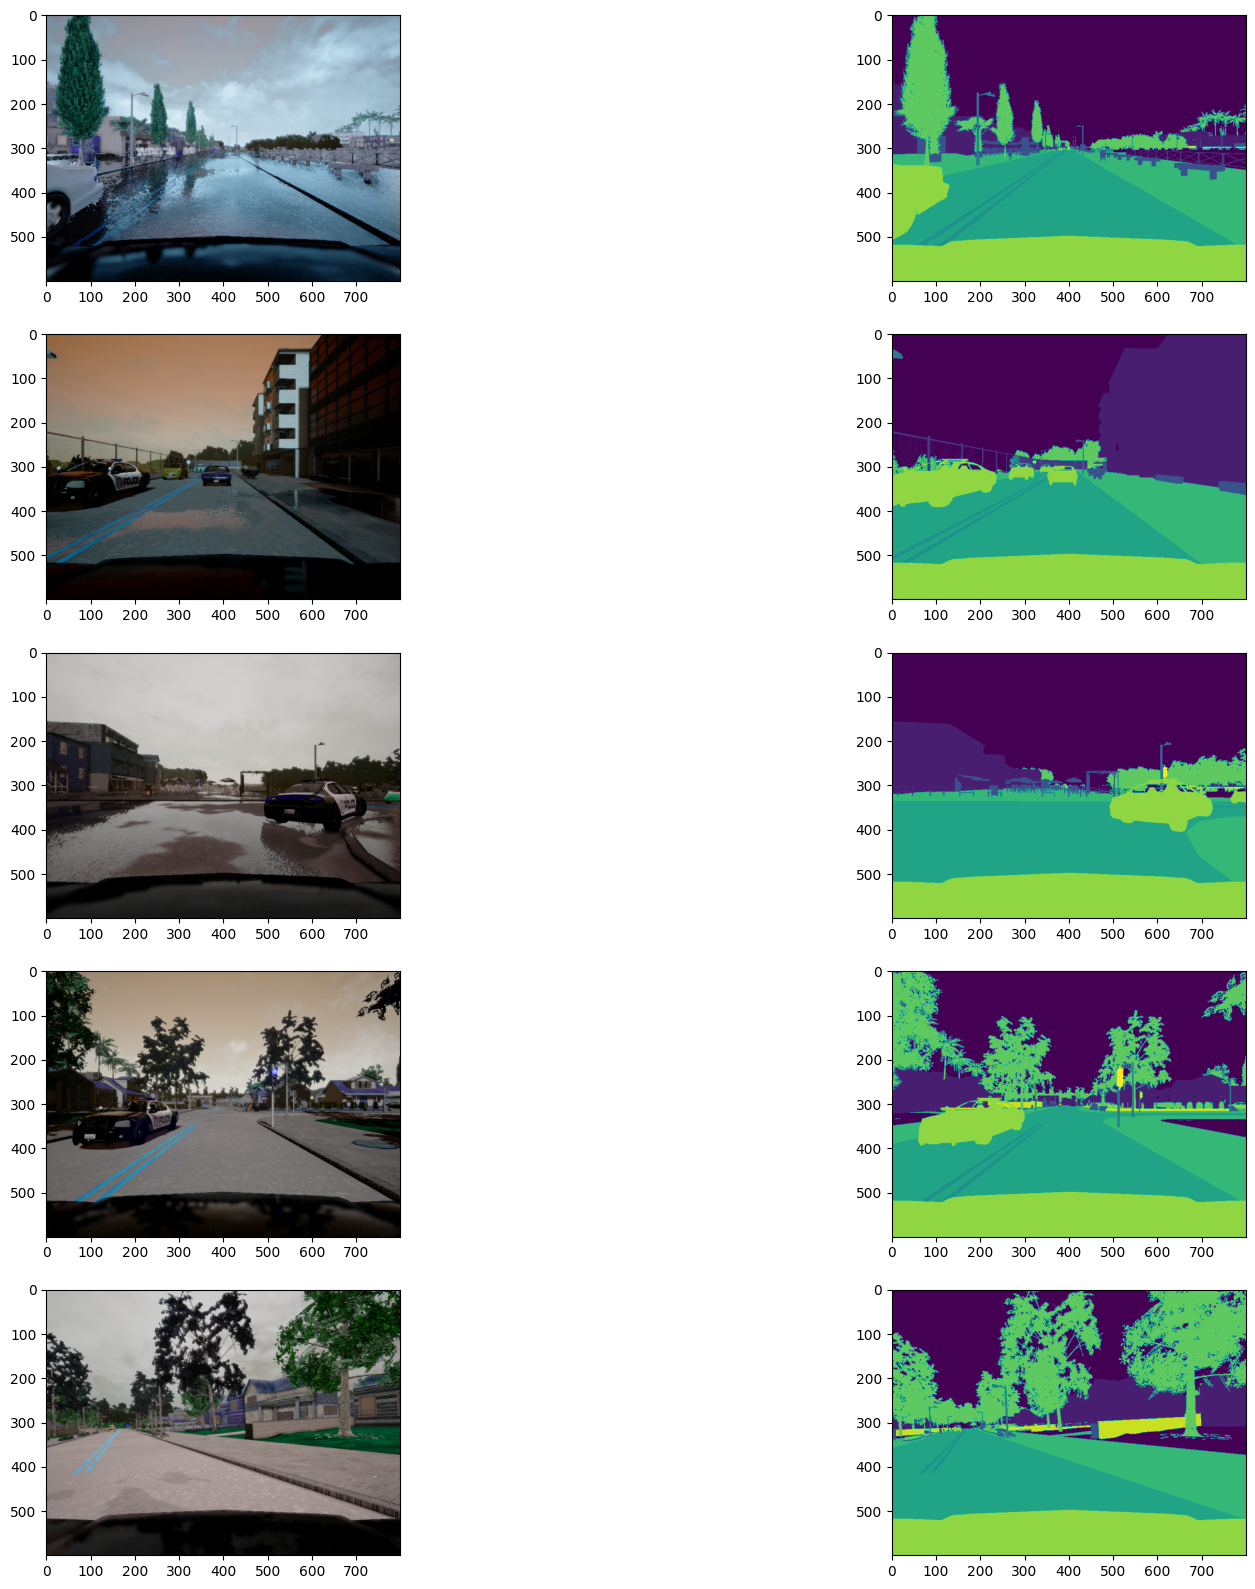

In [ ]:
nub = 5


f, axis = plt.subplots(nub,2, figsize=(20,20))

for i,x in enumerate(np.random.random_integers(0,5000,nub)):
    images = cv2.imread(img_path[x])
    masks = cv2.imread(masks_path[x])
    masks = tf.math.reduce_max(masks, axis=-1, keepdims=True)
    axis[i][0].imshow(images)
    axis[i][1].imshow(masks)

plt.show()


In [ ]:
train_masks_path, train_img_path = masks_path[:int(len(masks_path)*0.8)] , img_path[:int(len(masks_path)*0.8)]
val_masks_path, val_img_path = masks_path[int(len(masks_path)*0.8):] , img_path[int(len(masks_path)*0.8):]

In [ ]:
from numpy.core.numeric import indices
imshape = (512, 512, 3)
numclasses = 13

seq = iaa.Sequential([

    iaa.Sharpen((0.0, 1.0)),
    iaa.Affine(scale=(0.5, 1.5),rotate=(-45, 45)),


], random_order=True)






class DataGen(tf.keras.utils.Sequence):

    def __init__(self,image_paths, annot_paths, batch_size=32, shuffle=True, augment=False, subtitle='train', split_train = 0.8, seed=1):

        self.image_paths = image_paths
        self.annot_paths = annot_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.subtitle = subtitle
        self.split_train = split_train
        self.seed = seed



        np.random.seed(self.seed)
        self.indices = np.arange(len(self.image_paths))
        np.random.shuffle(self.indices)


        split_num = int(len(self.image_paths)* self.split_train)
        self.train_indices = self.indices[:split_num]
        self.val_indices = self.indices[split_num:]



        self.on_epoch_end()


    def __len__(self):
        # Denotes the number of batches per epoch
        return int(np.floor(len(self.train_indices) / self.batch_size))


    def __getitem__(self, index):
        # Generate indexes of the batch
        if self.subtitle =='train':
          indexes = self.train_indices[index*self.batch_size:(index+1)*self.batch_size]

        else:
          indexes = self.val_indices[index*self.batch_size:(index+1)*self.batch_size]

        image_paths = [self.image_paths[k] for k in indexes]
        annot_paths = [self.annot_paths[k] for k in indexes]

        X, y = self.__data_generation(image_paths, annot_paths)

        return X, y


    def on_epoch_end(self):
        # Updates indexes after each epoch

        if self.shuffle == True:
            np.random.shuffle(self.train_indices)
            np.random.shuffle(self.val_indices)





    def __data_generation(self, image_paths, annot_paths):
        X = np.empty((self.batch_size, imshape[0],imshape[1],imshape[2]), dtype= np.float32)
        Y = np.empty((self.batch_size, imshape[0],imshape[1],numclasses), dtype= np.float32)
        for i, (im_path, an_path) in enumerate(zip(image_paths, annot_paths)):
            img = cv2.imread(im_path,1)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(an_path)
            img = cv2.resize(img, (imshape[1], imshape[0]))
            mask = cv2.resize(mask, (imshape[1], imshape[0]))
            mask = tf.math.reduce_max(mask, axis=-1)

            mask = np.array(mask)



            #Data Augmentation
            # img, mask = seq(image=img, segmentation_maps=mask)
            aug_det = seq.to_deterministic()
            img = aug_det.augment_image(img)
            mask = aug_det.augment_image(mask)
            mask = tf.one_hot(mask, depth=13, dtype=tf.uint8)

            X[i,] = img.astype(np.float32)/255
            Y[i,] = mask
        return X,Y









In [ ]:
# dg = DataGen(img_path, masks_path, batch_size=16, shuffle=True, augment=False, subtitle='train', split_train = 0.8, seed=1)
# val_dg = DataGen(img_path, masks_path, batch_size=16, shuffle=True, augment=False, subtitle='val', split_train = 0.8, seed=1)





dg = DataGen(train_img_path, train_masks_path, batch_size=4, shuffle=True, augment=False, subtitle='train', split_train = 1, seed=12)
val_dg = DataGen(val_img_path, val_masks_path, batch_size=4, shuffle=True, augment=False, subtitle='train', split_train = 1, seed=12)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size, activation=activation, padding=padding)(x)
    x = BatchNormalization()(x)
    return x

def unet_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = conv_block(pool4, 1024)

    # Decoder
    up1 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    up1 = concatenate([up1, conv4], axis=-1)
    up1 = conv_block(up1, 512)

    up2 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(up1)
    up2 = concatenate([up2, conv3], axis=-1)
    up2 = conv_block(up2, 256)

    up3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(up2)
    up3 = concatenate([up3, conv2], axis=-1)
    up3 = conv_block(up3, 128)

    up4 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(up3)
    up4 = concatenate([up4, conv1], axis=-1)
    up4 = conv_block(up4, 64)

    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(up4)

    model = Model(inputs, outputs)
    return model

patch_size = (256, 256)
stride = 128

num_classes = 13  # Adjust based on the number of segmentation classes in your dataset



In [ ]:
#reate the U-Net model
model = unet_model(imshape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
def dice(y_true, y_pred, smooth=1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
سخىغ import shutil

model_filename = 'best2_model.h5'

drive_folder_path = '/content/drive/My Drive/machine learning/'


model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[ 'accuracy',dice_coefficient])

checkpoint = ModelCheckpoint('/content/drive/My Drive/machine learning/Unet_model.h5', monitor='val_dice_coefficient', save_best_only=True, mode='max', verbose=1)
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", restore_best_weights=True, patience=10 )

model.fit_generator(generator=dg,
                    steps_per_epoch=len(dg),
                    epochs=200, verbose=1,
                    callbacks=[checkpoint, EarlyStopping],validation_data= val_dg)

<ipython-input-18-1f6307f467e7>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=dg,


Epoch 1/200
1000/1000 [==============================] - ETA: 0s - loss: 0.4750 - accuracy: 0.8613 - dice_coefficient: 0.8020
Epoch 1: val_dice_coefficient improved from -inf to 0.74926, saving model to /content/drive/My Drive/machine learning/Unet_model.h5
1000/1000 [==============================] - 1331s 1s/step - loss: 0.4750 - accuracy: 0.8613 - dice_coefficient: 0.8020 - val_loss: 0.6954 - val_accuracy: 0.7990 - val_dice_coefficient: 0.7493
Epoch 2/200
1000/1000 [==============================] - ETA: 0s - loss: 0.2737 - accuracy: 0.9207 - dice_coefficient: 0.8850
Epoch 2: val_dice_coefficient improved from 0.74926 to 0.83088, saving model to /content/drive/My Drive/machine learning/Unet_model.h5
1000/1000 [==============================] - 1286s 1s/step - loss: 0.2737 - accuracy: 0.9207 - dice_coefficient: 0.8850 - val_loss: 0.4376 - val_accuracy: 0.8816 - val_dice_coefficient: 0.8309
Epoch 3/200
1000/1000 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9

In [ ]:
from google.colab import drive
from keras.models import load_model

# Mount Google Drive
drive.mount('/content/drive')


model_path = '/content/drive/My Drive/machine learning/best2_model.h5'


model = load_model(model_path, custom_objects={'dice_coefficient' : dice_coefficient})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
x,y = val_dg.__getitem__(1)

In [ ]:
pre = loaded_model.predict(x)

1/1 [==============================] - 22s 22s/step


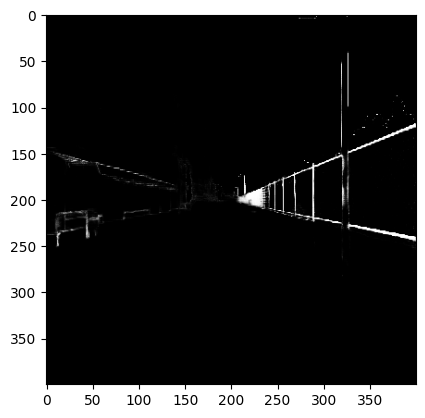

In [ ]:
plt.imshow(pre[1,:,:,2], cmap='gray')

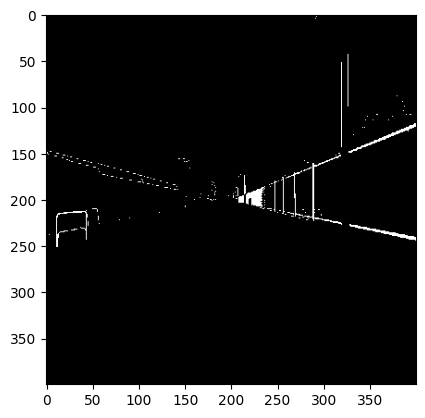

In [ ]:
plt.imshow(y[1,:,:,2], cmap='gray')